# Generate inputs for prior, computed by pkg/smooth

1. smooth2Dscales001.meta/data: 2 2D fields with
    - 1 * dXC
    - 1 * dYC
    
2. smooth3DscalesH001.meta/data: 2 3D fields, aka 100 2D fields, where 
    - 1-50 have 1*dXC
    - 51-100 have 1*dYC
    
3. smooth3DscalesZ001.meta/data: 1 3D field with
    - 1 * dRC 
    

In [1]:
import os
import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
import MITgcmutils as mut

from pych import horizontal_map

In [2]:
grid_dir = '/workspace/grids/pig_08'
ds = open_mdsdataset(data_dir=grid_dir,grid_dir=grid_dir,geometry='sphericalpolar',iters=None)

/workspace/xmitgcm/xmitgcm/mds_store.py:841: UserWarning: Couldn't find available_diagnostics.log in /workspace/grids/pig_08 or /workspace/grids/pig_08. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))


In [3]:
def smooth_writer(fname,arr,comments=None):
    if comments is not None:
        mut.wrmds(fbase=fname,arr=arr,dataprec='float64',simulation=comments)
    else:
        mut.wrmds(fbase=fname,arr=arr,dataprec='float64')
    print('%s.meta/data files written ...' % fname)

In [12]:
smooth_dir = '/workspace/results/pig/shicoeff-optim/pig_prior_1dx_08'
if not os.path.isdir(smooth_dir):
    print(f'Making directory: {smooth_dir}')
    os.makedirs(smooth_dir)

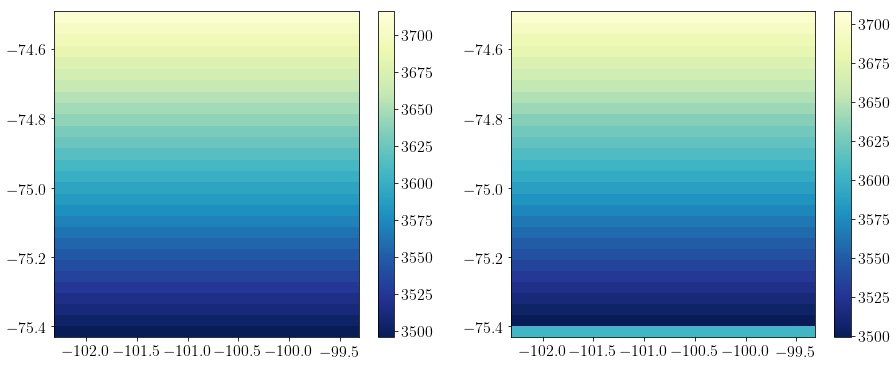

(100, 30, 25)


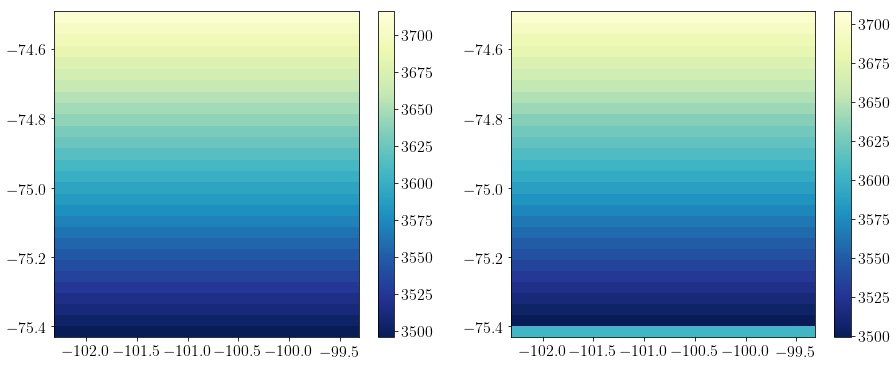

(50, 30, 25)


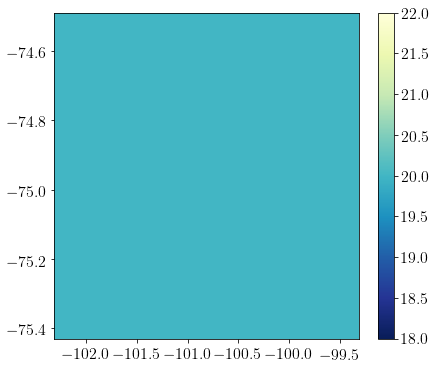

In [6]:
horizontal_scales_2d = np.stack((ds.dxC.values,ds.dyC.values),axis=0)
horizontal_scales_3d = np.concatenate((np.tile(ds.dxC.values, [50,1,1]),
                                 np.tile(ds.dyC.values, [50,1,1])))
# some verification ...
horizontal_map(ds.XC,ds.YC,horizontal_scales_2d[0,:,:],horizontal_scales_2d[1,:,:])
print(np.shape(horizontal_scales_3d))
horizontal_map(ds.XC,ds.YC,horizontal_scales_3d[0,:,:],horizontal_scales_3d[99,:,:])

vertical_scales = np.full_like(ds.hFacC.values,ds.drF.mean())

# verification...
print(np.shape(vertical_scales))
horizontal_map(ds.XC,ds.YC,vertical_scales)

In [9]:
smooth_writer(('%s/smooth2Dscales001' % smooth_dir), arr=horizontal_scales_2d, 
              comments='2 2D fields. 1*dxC, 1*dyC. Concatenated on 3rd dim.'
             )
smooth_writer(('%s/smooth3DscalesH001' % smooth_dir), arr=horizontal_scales_3d, 
              comments='2 3D fields. 1*dxC, 1*dyC. Both 3D fields, concatenated on 3rd dim.'
             )
smooth_writer(('%s/smooth3DscalesZ001' % smooth_dir), arr=vertical_scales, 
              comments='1 3D field. 1*drF. Constant across x,y dimensions.'
             )

pig_prior_1dx_08/smooth2Dscales001.meta/data files written ...
pig_prior_1dx_08/smooth3DscalesH001.meta/data files written ...
pig_prior_1dx_08/smooth3DscalesZ001.meta/data files written ...


# Now read in smoothness

1. smooth2Doperator: contains 

#### $\kappa = (\kappa_{ux} 0 , 0 \kappa_{vy})$
#### $\kappa_{ux}(\mathbf{x}) = \frac{L_{x}^2}{2\tau}$
#### $\kappa_{vy}(\mathbf{x}) = \frac{L_{y}^2}{2\tau}$

where $\tau = $ `nbt` `delTime` = `nbt` because `delTime`=1, integration time for diffusion operator

smooth3Doperator contains, in this ridiculous order
    
#### $\kappa_{wx},\kappa_{wy},\kappa_{wz},\kappa_{ux},\kappa_{vy},\kappa_{uz},\kappa_{vz},\kappa_{uy},\kappa_{vx},\kappa_R$
    
where $\kappa_R$ is a way to smooth vertical scales separately


2. smooth(2/3)Dnorm: contains amplification factor for WC01 algorithm

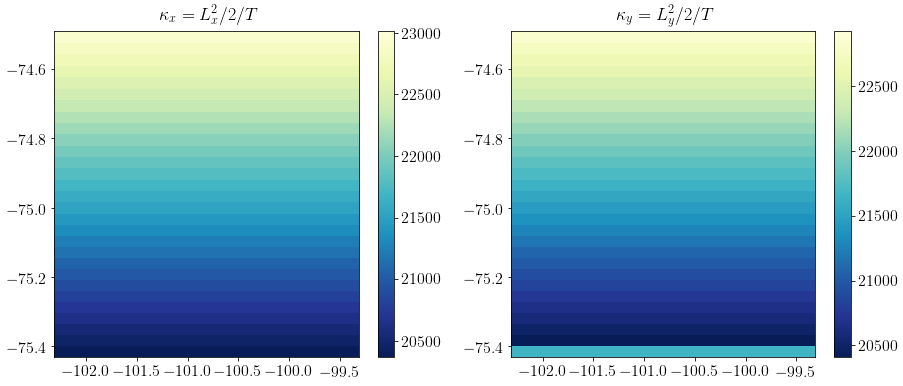

In [14]:
#run_dir = '/workspace/ase-adjoint/pig/generic/run_smooth'
operator_2d = mut.rdmds(('%s/smooth2Doperator001' % smooth_dir))
norm_2d = mut.rdmds(('%s/smooth2Dnorm001' % smooth_dir))

horizontal_map(ds.XC,ds.YC,operator_2d[0,:,:],operator_2d[1,:,:],
          title1='$\kappa_x = L_x^2/2/T$',
          title2='$\kappa_y = L_y^2/2/T$'
         )
horizontal_map(ds.XC,ds.YC,norm_2d,title1='$\Lambda_{2D}$')

(10, 50, 30, 25)
(50, 30, 25)


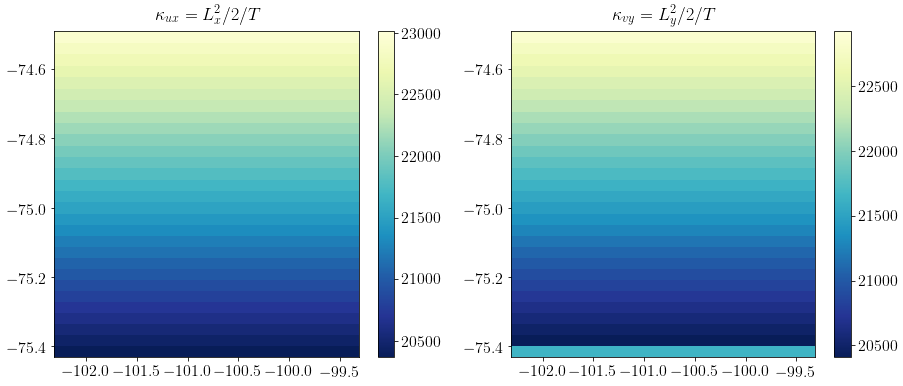

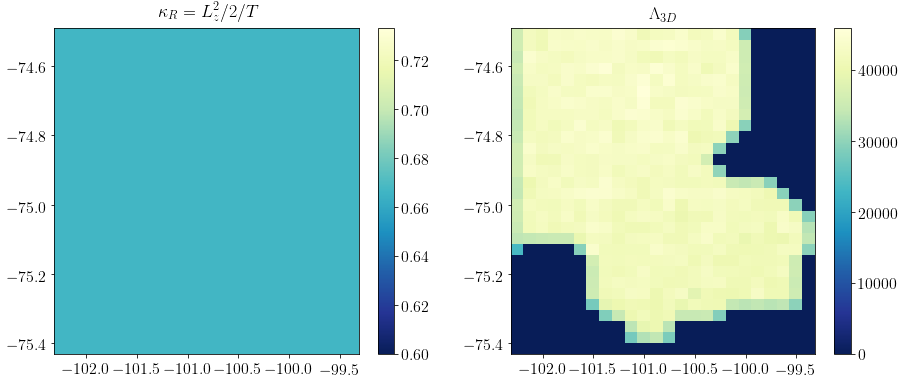

In [15]:
#run_dir = '/workspace/ase-adjoint/pig/generic/run_smooth'
operator_3d = mut.rdmds(('%s/smooth3Doperator001' % smooth_dir))
norm_3d = mut.rdmds(('%s/smooth3Dnorm001' % smooth_dir))

print(np.shape(operator_3d))
print(np.shape(norm_3d))

horizontal_map(ds.XC,ds.YC,operator_3d[3,:,:,:],operator_3d[4,:,:,:],
          title1='$\kappa_{ux} = L_x^2/2/T$',
          title2='$\kappa_{vy} = L_y^2/2/T$'
         )
horizontal_map(ds.XC,ds.YC,operator_3d[-1,:,:,:],norm_3d[0,:,:],
          title1='$\kappa_R = L_z^2/2/T$',title2='$\Lambda_{3D}$')